In [1]:
from amuse.units import units
from amuse.lab import Huayno, nbody_system, new_galactics_model
from amuse.lab import Gadget2
from amuse.community.ph4.interface import ph4
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from amuse.couple import bridge
from amuse.community.hermite.interface import Hermite
from amuse.community.bhtree.interface import BHTree
from astropy.io import fits

In [2]:
%%time

# Milky Way := Mdisk = 4.5 Mbulge | Mhalo = 100 Mbulge
# Andromeda := Mdisk = 4-7 Mbulge | Mhalo = 87 Mbulge
# Mdisk = 5 Mbulge, Mhalo = 95 Mbulge

n_halo  = 20000
n_bulge = 10000
n_disk  = 10000
M_galaxy = 1e12 | units.MSun
R_galaxy = 80  | units.kpc
converter = nbody_system.nbody_to_si(M_galaxy, R_galaxy)

galaxy1 = new_galactics_model(n_halo,
                                converter,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge,
                                disk_number_of_particles=n_disk)
# Order of particles: Disk => Bulge => Halo

CPU times: user 2.11 s, sys: 1.23 s, total: 3.34 s
Wall time: 5.66 s


In [3]:
%%time
M_galaxy_2 = 5e11 | units.MSun
R_galaxy_2 = 50  | units.kpc
converter_2 = nbody_system.nbody_to_si(M_galaxy_2, R_galaxy_2)
galaxy2 = new_galactics_model(n_halo,
                                converter_2,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge,
                                disk_number_of_particles=n_disk)

CPU times: user 2.53 s, sys: 1.2 s, total: 3.74 s
Wall time: 3.93 s


In [4]:
%%time
galaxy1.rotate(0., np.pi/2, 0.)
galaxy2.x  += 400 | units.kpc
galaxy2.vx += -100 |units.kms
galaxy2.vy += +10 |units.kms

CPU times: user 3.01 ms, sys: 2.34 ms, total: 5.35 ms
Wall time: 4.35 ms


In [5]:
converter = nbody_system.nbody_to_si(1.e12|units.MSun, 100|units.kpc)
dynamics = BHTree(converter) # ph4 Does the trick, but is kinda slow
dynamics.parameters.epsilon_squared = (100|units.parsec)**2
set1 = dynamics.particles.add_particles(galaxy1)
set2 = dynamics.particles.add_particles(galaxy2)

In [6]:
%%time
n_halo_test  = 1000
n_disk_test  = 1000
n_bulge_test = 1000

test_particles_1 = new_galactics_model(n_halo_test,
                                converter,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge_test,
                                disk_number_of_particles=n_disk_test)

test_particles_2 = new_galactics_model(n_halo_test,
                                converter_2,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge_test,
                                disk_number_of_particles=n_disk_test)

CPU times: user 3.44 s, sys: 2.76 s, total: 6.2 s
Wall time: 7.34 s


In [7]:
#set the mass of the test particles to 0
test_particles_1.mass = 0 |units.kg
test_particles_2.mass = 0 |units.kg

#we're only interested in the particles from the stars, and not the halo.
test_particles_1_stars = test_particles_1[:int(n_bulge_test+n_disk_test)]
test_particles_2_stars = test_particles_2[:int(n_bulge_test+n_disk_test)]

#rotate and translate in the same way as the galaxies
test_particles_1_stars.rotate(0., np.pi/2, 0.)
test_particles_2_stars.x  += 400 | units.kpc
test_particles_2_stars.vx += -100 |units.kms
test_particles_2_stars.vy += +10 |units.kms

star_dynamics = BHTree(converter)
star_set_1 = star_dynamics.particles.add_particles(test_particles_1_stars)
star_set_2 = star_dynamics.particles.add_particles(test_particles_2_stars)

In [8]:
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(star_dynamics, (dynamics,) )
gravity.add_system(dynamics)
#gravity.add_system(star_dynamics, (galaxy2,) )
#gravity.add_system(galaxy2, (galaxy1,) )
#gravity.add_system(galaxy1, (galaxy2,) )
channel = star_dynamics.particles.new_channel_to(star_dynamics.particles)

In [9]:
gravity.timestep = 100|units.Myr
threshold = 20. |units.Myr 

times = np.arange(0., 5000, 100) | units.Myr
for time in tqdm(range(len(times))):
    gravity.evolve_model(times[time])
    if times[time] %threshold == 0|units.Myr:
        channel.copy()
        '''
        #saving the orbit of the stars with mass
        plt.figure(figsize = (10,8))
        plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3,label = 'Big galaxy')
        plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3,label = 'Small galaxy')
        plt.title("Disk + Bulge \n time = " +str(times[time]) )
        plt.legend()
        plt.xlabel("x [kpc]")
        plt.ylabel("y [kpc]")
        plt.xlim(-200,500)
        plt.axis("equal")
        #plt.ylim(-100,100)
        plt.savefig('./merge_plots/snap%04d.png'%time)
        #plt.show()
        plt.close()
        '''
        #saving the orbit of the massless tracers
        plt.figure(figsize = (10,8))
        plt.scatter(star_set_1.x[:int(n_disk_test)].value_in(units.kpc), star_set_1.y[:int(n_disk_test)].value_in(units.kpc), s=1,label = 'Big galaxy (disk)',color = 'b')
        plt.scatter(star_set_2.x[:int(n_disk_test)].value_in(units.kpc), star_set_2.y[:int(n_disk_test)].value_in(units.kpc), s=1,label = 'Small galaxy (disk)', color ='k')
        plt.scatter(star_set_1.x[int(n_disk_test):int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_1.y[int(n_disk_test):int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1,label = 'Big galaxy (bulge)',color = 'r')
        plt.scatter(star_set_2.x[int(n_disk_test):int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_2.y[int(n_disk_test):int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1,label = 'Small galaxy bulge',color = 'magenta')
        plt.title("Disk + Bulge for test particles \n time = " +str(times[time]) )
        plt.legend()
        plt.xlabel("x [kpc]")
        plt.ylabel("y [kpc]")
        plt.xlim(-200,600)
        #plt.axis("equal")
        plt.ylim(-200,200)
        plt.savefig('./star_plots/snapshots/snap%04d.png'%time)
        plt.close()
        
        file = open("time.txt","w")
        file.write(str(times[time]))
        file.write("\n")
        #put the last data in fits files
        col1 = fits.Column(name='star_1_x', format='E', array=np.array(star_set_1.x.value_in(units.m)))
        col2 = fits.Column(name='star_1_y', format='E', array=np.array(star_set_1.y.value_in(units.m)))
        col3 = fits.Column(name='star_1_z', format='E', array=np.array(star_set_1.z.value_in(units.m)))
        col4 = fits.Column(name='star_1_vx', format='E', array=np.array(star_set_1.vx.value_in(units.kms)))
        col5 = fits.Column(name='star_1_vy', format='E', array=np.array(star_set_1.vy.value_in(units.kms)))
        col6 = fits.Column(name='star_1_vz', format='E', array=np.array(star_set_1.vz.value_in(units.kms)))

        col11 = fits.Column(name='star_2_x', format='E', array=np.array(star_set_2.x.value_in(units.m)))
        col12 = fits.Column(name='star_2_y', format='E', array=np.array(star_set_2.y.value_in(units.m)))
        col13 = fits.Column(name='star_2_z', format='E', array=np.array(star_set_2.z.value_in(units.m)))
        col14 = fits.Column(name='star_2_vx', format='E', array=np.array(star_set_2.vx.value_in(units.kms)))
        col15 = fits.Column(name='star_2_vy', format='E', array=np.array(star_set_2.vy.value_in(units.kms)))
        col16 = fits.Column(name='star_2_vz', format='E', array=np.array(star_set_2.vz.value_in(units.kms)))
        
        col21 = fits.Column(name='set_1_x', format='E', array=np.array(set1.x.value_in(units.m)))
        col22 = fits.Column(name='set_1_y', format='E', array=np.array(set1.y.value_in(units.m)))
        col23 = fits.Column(name='set_1_z', format='E', array=np.array(set1.z.value_in(units.m)))
        col24 = fits.Column(name='set_1_vx', format='E', array=np.array(set1.vx.value_in(units.kms)))
        col25 = fits.Column(name='set_1_vy', format='E', array=np.array(set1.vy.value_in(units.kms)))
        col26 = fits.Column(name='set_1_vz', format='E', array=np.array(set1.vz.value_in(units.kms)))

        
        col31 = fits.Column(name='set_2_x', format='E', array=np.array(set2.x.value_in(units.m)))
        col32 = fits.Column(name='set_2_y', format='E', array=np.array(set2.y.value_in(units.m)))
        col33 = fits.Column(name='set_2_z', format='E', array=np.array(set2.z.value_in(units.m)))
        col34 = fits.Column(name='set_2_vx', format='E', array=np.array(set2.vx.value_in(units.kms)))
        col35 = fits.Column(name='set_2_vy', format='E', array=np.array(set2.vy.value_in(units.kms)))
        col36 = fits.Column(name='set_2_vz', format='E', array=np.array(set2.vz.value_in(units.kms)))

        cols = fits.ColDefs([col1,col2,col3,col4,col5,col6,col11,col12,col13,col14,col15,col16,col21,col22,col23,col24,col25,col26,col31,col32,col33,col34,col35,col36])
        hdu = fits.BinTableHDU.from_columns(cols)
        hdu.writeto('data.fits',overwrite =True)
        file.write(str(times[time]))
        file.close()
        
        
gravity.stop()

100%|██████████| 50/50 [05:48<00:00,  6.98s/it]


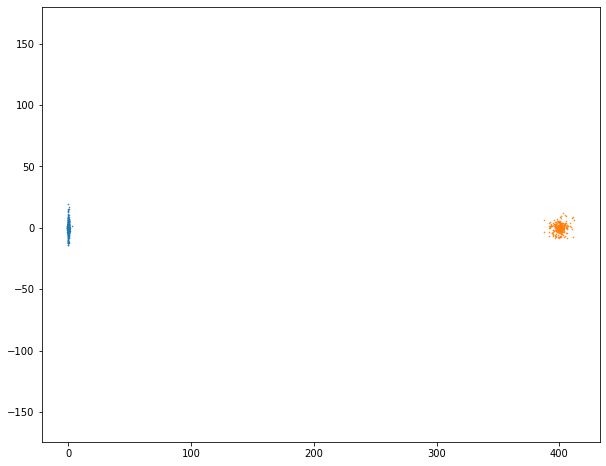

'\nplt.figure(figsize=[10,8])\nplt.scatter(galaxy1.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)\nplt.scatter(galaxy2.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)\nplt.axis("equal")\nplt.show()'

In [10]:
plt.figure(figsize=[10,8])
plt.scatter(galaxy1.x[:int(n_bulge+n_disk)].value_in(units.kpc), galaxy1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
plt.scatter(galaxy2.x[:int(n_bulge+n_disk)].value_in(units.kpc), galaxy2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
plt.axis("equal")
plt.show()

"""
plt.figure(figsize=[10,8])
plt.scatter(galaxy1.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)
plt.scatter(galaxy2.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)
plt.axis("equal")
plt.show()"""

In [11]:
plt.figure(figsize=[10,8])
plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
plt.axis("equal")
plt.show()

"""
plt.figure(figsize=[10,8])
plt.scatter(set1.x[int(n_bulge+n_disk):].value_in(units.kpc), set1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=1.5)
plt.scatter(set2.x[int(n_bulge+n_disk):].value_in(units.kpc), set2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=1.5)
plt.title("Halo")
plt.axis("equal")
plt.show()"""

wrapped<wrapped<wrapped<wrapped<function: int get_position(int index_of_the_particle)
output: double x, double y, double z, int __result>>>>


Exception: While calling get_position of BHTree: No transition from current state state 'STOPPED' to state 'RUN' possible

<Figure size 720x576 with 0 Axes>

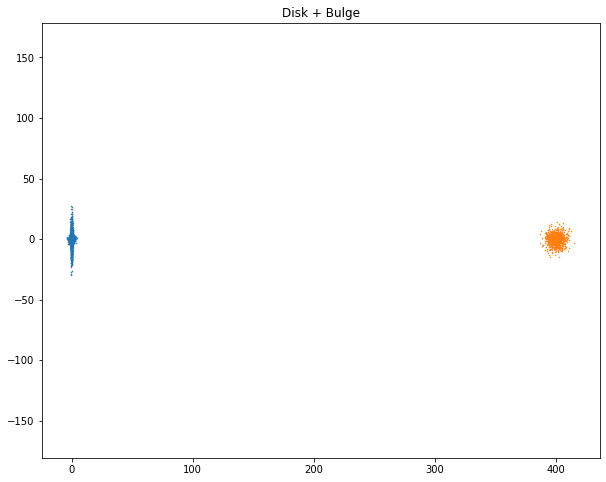

In [12]:
plt.figure(figsize=[10,8])
plt.scatter(test_particles_1_stars.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), test_particles_1_stars.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=0.3)
plt.scatter(test_particles_2_stars.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), test_particles_2_stars.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=0.3)
plt.title("Disk + Bulge")
plt.axis("equal")
plt.show()

In [13]:
plt.figure(figsize=[10,8])
plt.scatter(star_set_1.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_1.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1.5)
plt.scatter(star_set_2.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_2.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
#plt.axis("equal")
#plt.ylim(-120, 120)
#plt.xlim(-150, 160)
plt.show()

plt.figure(figsize=[10,8])
plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
plt.axis("equal")
plt.show()

wrapped<wrapped<wrapped<wrapped<function: int get_position(int index_of_the_particle)
output: double x, double y, double z, int __result>>>>


Exception: While calling get_position of BHTree: No transition from current state state 'STOPPED' to state 'RUN' possible

<Figure size 720x576 with 0 Axes>

In [ ]:
plt.figure(figsize=[10,8])
plt.scatter(star_set_1.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_1.z[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1.5)
plt.scatter(star_set_2.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_2.z[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
#plt.axis("equal")
#plt.ylim(-120, 120)
#plt.xlim(-150, 160)
plt.show()

In [14]:
file = fits.open("data.fits")
a = file[1].data

In [15]:
x = a.field("star_1_x")
print(x[:n_disk_test+n_bulge_test])
#test_particles_1.x = x|units.m

[ -2.19331969e+20  -2.90545924e+22  -4.55018683e+21 ...,  -9.66405286e+22
  -1.11610935e+23   3.68744998e+21]


In [16]:
b = open("time.txt")
c = b.read()
print(c)

4900.0 Myr
4900.0 Myr


In [81]:
galaxies_x = np.array([a.field("set_1_x"),a.field("set_2_x")],dtype = "float64")#/3.086e19
galaxies_y = np.array([a.field("set_1_y"),a.field("set_2_y")],dtype = "float64")#/3.086e19
galaxies_z = np.array([a.field("set_1_z"),a.field("set_2_z")],dtype = "float64")#/3.086e19
print(np.mean(galaxies_x))
print(np.mean(galaxies_y))
print(np.mean(galaxies_z))

-1.66392936672e+21
3.53592000103e+20
-9.08929842292e+18


In [82]:
galaxies_vx = np.array([a.field("set_1_vx"),a.field("set_2_vx")],dtype = 'float64')
galaxies_vy = np.array([a.field("set_1_vy"),a.field("set_2_vy")],dtype = 'float64')
galaxies_vz = np.array([a.field("set_1_vz"),a.field("set_2_vz")],dtype = 'float64')
print(np.mean(galaxies_vx))
print(np.mean(galaxies_vy))
print(np.mean(galaxies_vz))

-32.4363179403
3.17101754269
-0.330338440356


In [84]:
stars_x = np.array([a.field("star_1_x"),a.field("star_2_x")],dtype = "float64")#/3.086e19
stars_y = np.array([a.field("star_1_y"),a.field("star_2_y")],dtype = "float64")#/3.086e19
stars_z = np.array([a.field("star_1_z"),a.field("star_2_z")],dtype = "float64")#/3.086e19
stars_vx = np.array([a.field("star_1_vx"),a.field("star_2_vx")],dtype = "float64")
stars_vy = np.array([a.field("star_1_vy"),a.field("star_2_vy")],dtype = "float64")
stars_vz = np.array([a.field("star_1_vz"),a.field("star_2_vz")],dtype = "float64")

star_x_wrt_mean_galaxies = stars_x - np.mean(galaxies_x)
star_y_wrt_mean_galaxies = stars_y - np.mean(galaxies_y)
star_z_wrt_mean_galaxies = stars_z - np.mean(galaxies_z)
star_vx_wrt_mean_galaxies = stars_vx - np.mean(galaxies_vx)
star_vy_wrt_mean_galaxies = stars_vy - np.mean(galaxies_vy)
star_vz_wrt_mean_galaxies = stars_vz - np.mean(galaxies_vz)

In [86]:
print(star_x_wrt_mean_galaxies[0]**2)


[  2.08686164e+42   7.50248424e+44   8.33048216e+42 ...,   2.76866094e+42
   2.76866094e+42   2.76866094e+42]


In [88]:
dist_stars = np.sqrt(star_x_wrt_mean_galaxies[0]**2 + star_y_wrt_mean_galaxies[0]**2 + star_z_wrt_mean_galaxies[0]**2)
vel_stars  = np.sqrt(star_vx_wrt_mean_galaxies[0]**2 + star_vy_wrt_mean_galaxies[0]**2 + star_vz_wrt_mean_galaxies[0]**2)

print(len(np.where(dist_stars > 400*3.086e19)[0]))

G = 6.67e-11
total_mass_galaxies_in_kg = galaxy1.mass.sum().value_in(units.kg) + galaxy2.mass.sum().value_in(units.kg)
def v_escape(r,M):
    print(r)
    return(np.sqrt(2*G*M/r))

1397


In [90]:
v_esc_stars = v_escape(dist_stars,total_mass_galaxies_in_kg) /1000
print(v_esc_stars[:50])
print(vel_stars[:50])


[  1.78365944e+21   1.02854099e+23   3.32153412e+21 ...,   1.70110871e+21
   1.70110871e+21   1.70110871e+21]
[ 472.36339275   62.20444223  346.14880996  110.40982039  141.96391315
  403.53843784   85.82172897  103.79202745  191.8872165    87.28850725
  577.40576035  409.00043229   81.69043491  210.55595409   81.22868065
   70.6558145   502.51684988   76.3843098   294.36940006  433.06689172
  184.6179272    36.96978991  592.11676528  163.69513342  172.51875755
  657.53541869  320.0257645   832.76591641  166.57933393  408.61389768
  593.09713777   79.89001625   75.85532935  652.80911464  499.7038061
  508.81905366  342.84744904  412.57500089  525.35650043  283.56738995
  351.95571081  198.48357072   90.6944087    76.93867025  625.28573973
  350.64531626  204.48374815  591.92311622  251.43473329   93.70115672]
[  119.1350424    650.92016567   141.31372141   192.17479153    93.44346172
   120.67040392   329.50515551   259.22854994    29.03921165   318.68796429
   240.01537405    96.732318

In [41]:
np.max(star_x_wrt_mean_galaxies)

14551.104

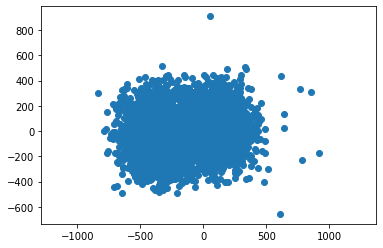

In [31]:
plt.scatter(np.array(galaxies_x)/(3.086e19),np.array(galaxies_y)/(3.086e19))
plt.axis("equal")
plt.show()


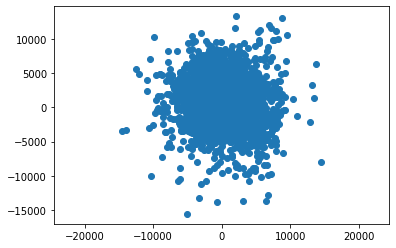

In [33]:
plt.scatter(np.array(stars_x)/(3.086e19),np.array(stars_y)/(3.086e19))
plt.axis("equal")
plt.show()

In [54]:
galaxy1.mass.sum().value_in(units.kg)

1.9889199999999981e+42